In [1]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, roc_auc_score
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import enum
import math


import warnings
warnings.filterwarnings('ignore')

In [2]:
def random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
PATH = '../input/petfinder-pawpularity-score'
train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))
sub = pd.read_csv(os.path.join(PATH, 'sample_submission.csv'))

In [4]:
train.shape

(9912, 14)

In [5]:
test.shape

(8, 13)

In [6]:
sub.shape

(8, 2)

In [7]:
train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [8]:
test.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [9]:
sub.head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,67.75
1,43a2262d7738e3d420d453815151079e,59.15
2,4e429cead1848a298432a0acad014c9d,20.02
3,80bc3ccafcc51b66303c2c263aa38486,94.53
4,8f49844c382931444e68dffbe20228f4,89.82


<AxesSubplot:>

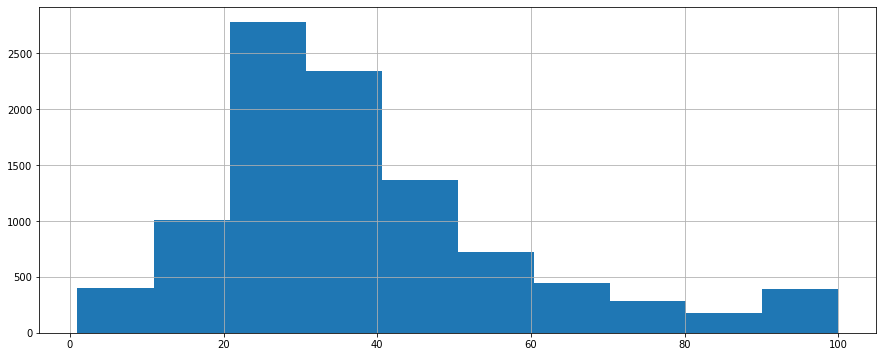

In [10]:
train.Pawpularity.hist(figsize=(15,6))

In [11]:
train.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [12]:
test.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
count,8.000000,8.00000,8.000000,8.00000,8.000000,8.000000,8.000000,8.000000,8.00000,8.000000,8.000000,8.000000
mean,0.625000,0.25000,0.625000,0.25000,0.375000,0.625000,0.500000,0.625000,0.25000,0.500000,0.625000,0.500000
std,0.517549,0.46291,0.517549,0.46291,0.517549,0.517549,0.534522,0.517549,0.46291,0.534522,0.517549,0.534522
min,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,1.000000,0.00000,1.000000,0.00000,0.000000,1.000000,0.500000,1.000000,0.00000,0.500000,1.000000,0.500000
75%,1.000000,0.25000,1.000000,0.25000,1.000000,1.000000,1.000000,1.000000,0.25000,1.000000,1.000000,1.000000
max,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


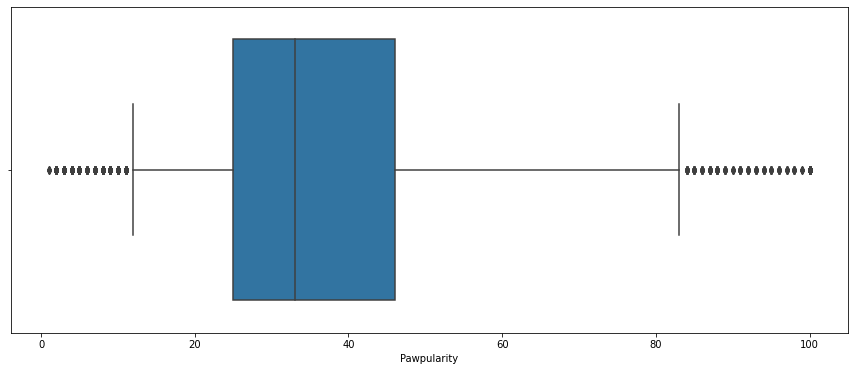

In [13]:
plt.rcParams["figure.figsize"] = (15,6)
ax = sns.boxplot(x=train.Pawpularity, whis=[5, 95])


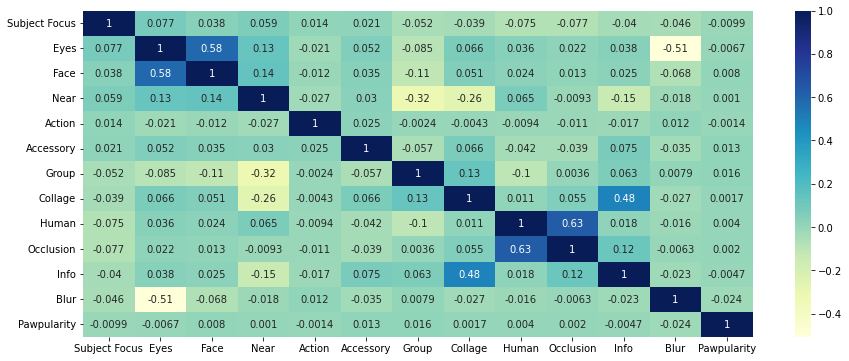

In [14]:
dataplot = sns.heatmap(train.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [15]:
columns = [col for col in train.columns if col not in ['Id', 'Pawpularity', 'bins'] ]

In [16]:
len(columns)

12

In [17]:
IMG_PATH = [os.path.join(PATH, 'train/'+idx+'.jpg')  for idx in train.Id]

In [18]:
def visualize_image(figsize=(16, 16), n_images=2):
    plt.figure(figsize=figsize)
    w = int(n_images ** .5)
    h = math.ceil(n_images / w) 
    all_names = IMG_PATH
    image_names = random.sample(all_names, n_images)
    for ind, image_name in enumerate(image_names):   
            img = cv2.imread(image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            plt.subplot(w, h, ind + 1)
            plt.imshow(img)
            plt.axis("off")          
    plt.show()

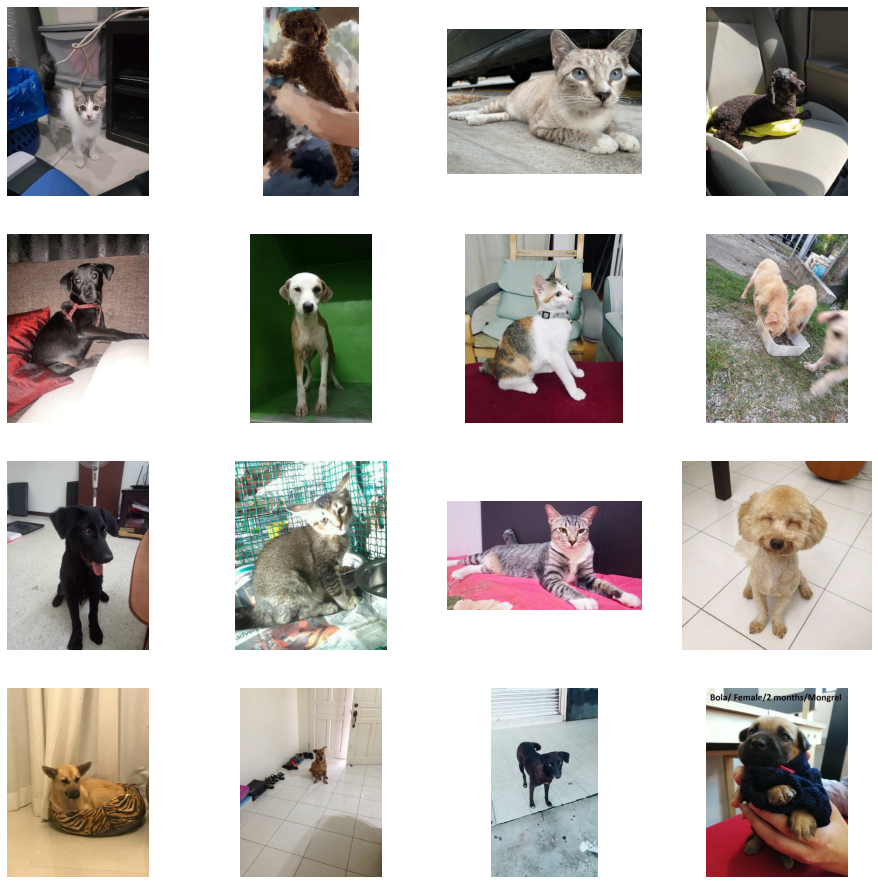

In [19]:
visualize_image(n_images=16)

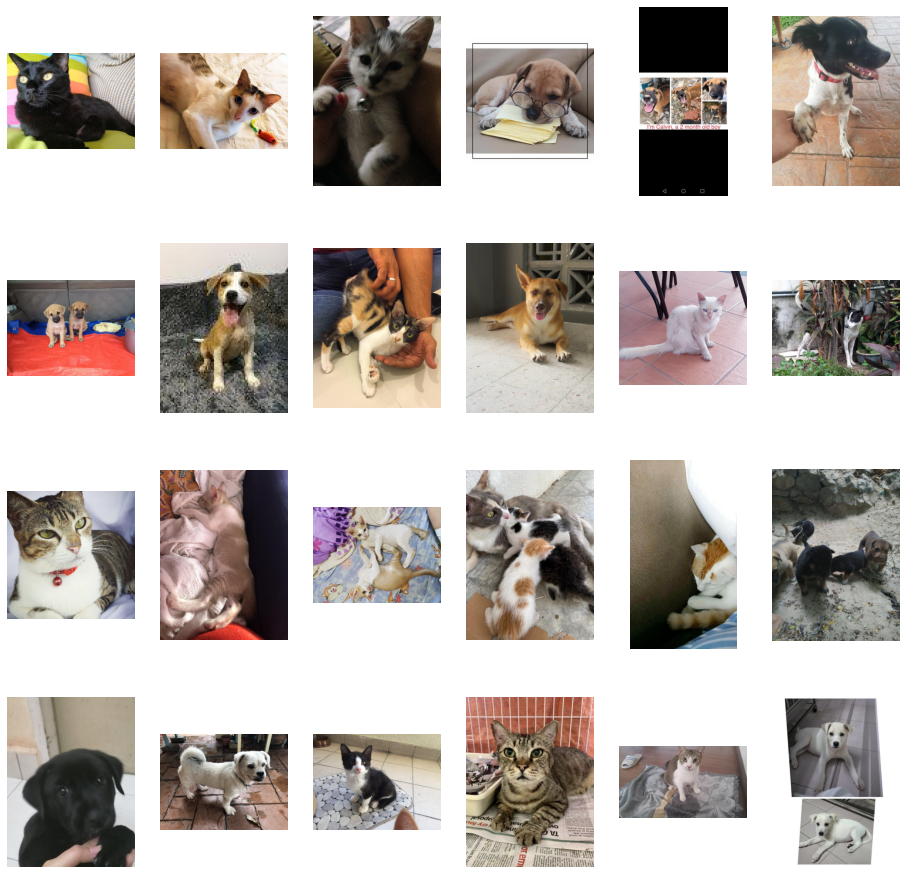

In [20]:
visualize_image(n_images=24)

In [21]:
xgb_params= {
        "n_estimators": 30000,
        "max_depth": 10,
        "objective":"reg:squarederror",
        "n_jobs": 4,
        "seed": 2001,
        'tree_method': "gpu_hist",
        "gpu_id": 0,
        "eval_metric": "rmse", 
        "subsample": 0.7,
        "colsample_bytree": 0.7,
        "learning_rate": 0.01
    }

In [22]:
class Config(enum.Enum):
    SEED = 2001
    N_FOLDS = 5
    EARLY_STOP = 300

In [23]:
random_seed(Config.SEED.value)

rmse_score = []

targets = train['Pawpularity'].values

num_bins = int(np.floor(1 + np.log2(len(train))))

train.loc[:, "bins"] = pd.cut(train["Pawpularity"], bins=num_bins, labels=False)

kf = StratifiedKFold(n_splits = Config.N_FOLDS.value, shuffle=True, random_state=Config.SEED.value)    
        
oof = np.zeros((train.shape[0],))
test_preds = 0

for f, (train_idx, val_idx) in tqdm(enumerate(kf.split(X=train, y=train.bins.values))):
        df_train, df_val = train.iloc[train_idx][columns], train.iloc[val_idx][columns]
        train_target, val_target = targets[train_idx], targets[val_idx]
        
        model = xgb.XGBRegressor(**xgb_params)
        
        model.fit(
            df_train[columns], 
            train_target,
            eval_set=[(df_val[columns], val_target)],
            early_stopping_rounds=Config.EARLY_STOP.value,
            verbose=500
        )
        
        oof_tmp = model.predict(df_val[columns])
        test_tmp = model.predict(test[columns])
        
        oof[val_idx] = oof_tmp
        test_preds += test_tmp/Config.N_FOLDS.value
        rmse = mean_squared_error(val_target, oof_tmp, squared=False)
        rmse_score.append(rmse)
        print(f'FOLD: {f} RMSE: {rmse} Mean RMSE: {np.mean(rmse_score)}')

0it [00:00, ?it/s]

[0]	validation_0-rmse:42.49411
[500]	validation_0-rmse:20.77199
[666]	validation_0-rmse:20.83668


1it [00:05,  5.87s/it]

FOLD: 0 RMSE: 20.729510538919893 Mean RMSE: 20.729510538919893
[0]	validation_0-rmse:42.44205
[500]	validation_0-rmse:20.60883
[707]	validation_0-rmse:20.63940


2it [00:09,  4.46s/it]

FOLD: 1 RMSE: 20.594300378524466 Mean RMSE: 20.66190545872218
[0]	validation_0-rmse:42.51786
[500]	validation_0-rmse:20.68887
[687]	validation_0-rmse:20.73452


3it [00:12,  3.86s/it]

FOLD: 2 RMSE: 20.666113349176253 Mean RMSE: 20.66330808887354
[0]	validation_0-rmse:42.47792
[500]	validation_0-rmse:20.61859
[710]	validation_0-rmse:20.65008


4it [00:15,  3.64s/it]

FOLD: 3 RMSE: 20.611702452582595 Mean RMSE: 20.650406679800803
[0]	validation_0-rmse:42.49974
[500]	validation_0-rmse:20.67976
[714]	validation_0-rmse:20.71923


5it [00:19,  3.87s/it]

FOLD: 4 RMSE: 20.671178918766575 Mean RMSE: 20.654561127593958


In [24]:
import pickle
pickle.dump(model, open('xgbmodel.sav', 'wb'))

In [25]:
sub['Pawpularity'] = test_preds
sub.to_csv('submission.csv', index=False)